# Overview

1. [__Importing data__](#1)
    1. [Loading csv files](#1.1)


2. [__Preprocessing data__](#2)
    1. [Droping NaNs](#2.1)
    2. [Cleaning dataset](#2.2)
    3. [Datetime](#2.3)
    4. [Selecting data from 2018 to 2022)](#2.4)
    5. [Selecting plans related to 112 incidents & rescue actions](#2.5)

3. [__Trial plots__](#3)
    1. [Number of protection plans activated per Catalonia regions](#3.1)
        1. [Províncies](#3.1.1)
        2. [Comarques](#3.1.2)
        3. [Municipis](#3.1.3)
        
    2. [Time evolution of protection plans](#3.2)
        1. [Grouped by províncies](#3.2.1)
        2. [Grouped by typology](#3.2.2)
       
    3. [Protection plans divided](#3.3)
        1. [Grouped by typology](#3.3.1)
        3. [Grouped by typology and província](#3.3.2)

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns


# 1. Importing data <a class="anchor" id="1"></a>

In [2]:
data_dir = "../dades/"
fig_dir = "figures/"

## 1.1. Loading csv files <a class="anchor" id="1.1"></a>

In [3]:
rescue_actions = pd.read_csv(data_dir+"Actuacions_en_salvaments_al_medi_natural_dels_Bombers_de_la_Generalitat_20231109.csv")
protection_plans = pd.read_csv(data_dir+"Registre_general_de_plans_de_protecci__civil_de_Catalunya_20231109.csv")
inc_112 = pd.read_csv(data_dir+"Dades_d_incidents_operatius_gestionats_pel_CAT112_20231110.csv")


https://analisi.transparenciacatalunya.cat/Seguretat/Actuacions-en-salvaments-al-medi-natural-dels-Bomb/fsum-2k6e
https://analisi.transparenciacatalunya.cat/Seguretat/Registre-general-de-plans-de-protecci-civil-de-Cat/xqqe-tgav
https://analisi.transparenciacatalunya.cat/Seguretat/Dades-d-incidents-operatius-gestionats-pel-CAT112/jq8m-d7cw
https://analisi.transparenciacatalunya.cat/Seguretat/Dades-de-trucades-operatives-gestionades-pel-CAT11/mfqb-sbx4

In [4]:
comarques = ["Alt Camp","Alt Empordà","Alt Penedès","Alt Urgell","Alta Ribagorça","Anoia","Aran","Bages","Baix Camp",
             "Baix Ebre","Baix Empordà","Baix Llobregat","Baix Penedès","Barcelonès","Berguedà","Cerdanya",
             "Conca de Barberà","Garraf","Garrigues","Garrotxa","Gironès","Maresme","Moianès","Montsià",
             "Noguera","Osona","Pallars Jussà","Pallars Sobirà","Pla d'Urgell","Pla de l'Estany","Priorat",
             "Ribera d'Ebre","Ripollès","Segarra","Segrià","Selva","Solsonès","Tarragonès","Terra Alta",
             "Urgell","Vallès Occidental","Vallès Oriental"]

# 2. Preprocessing data <a class="anchor" id="2"></a>

## 2.1. Dropping NaNs <a class="anchor" id="2.1"></a>

We only conserve data from Municipal Plans to study them geographically

In [5]:
rescue_actions.dropna(axis=0, inplace=True)
protection_plans.dropna(axis=0, inplace=True)
inc_112.dropna(axis=0, inplace=True)

In [6]:
rescue_actions = rescue_actions.reset_index().drop("index",axis=1)
protection_plans = protection_plans.reset_index().drop("index",axis=1)
inc_112 = inc_112.reset_index().drop("index",axis=1)

# 2.2. Cleaning dataset <a class="anchor" id="2.2"></a>

In [7]:
protection_plans.columns

Index(['Tipus pla', 'Número d'inscripció', 'Nom del pla', 'Estat',
       'Data d'homologació', 'Últim esdeveniment',
       'Data de l'últim esdeveniment', 'Ine5', 'Municipi', 'Comarca',
       'Servei territorial', 'Vegueria', 'Província'],
      dtype='object')

In [8]:
dropped_cols = ["Número d'inscripció","Data d'homologació","Estat","Ine5","Vegueria","Servei territorial"]

protection_plans = protection_plans.drop(dropped_cols,axis=1)

In [9]:
for i in range(0,protection_plans.shape[0]):
    protection_plans["Nom del pla"][i] = protection_plans["Nom del pla"][i].split(" ")

    if protection_plans["Nom del pla"][i][0] == "PAM" and protection_plans["Nom del pla"][i][1] == "Pla":
        protection_plans["Nom del pla"][i] = "PAM PEEM"
        
    if protection_plans["Nom del pla"][i][0] == "PAM" or protection_plans["Nom del pla"][i][0] == "Pam" and protection_plans["Nom del pla"][i][1] != "Pla":
        protection_plans["Nom del pla"][i] =  f"PAM {protection_plans['Nom del pla'][i][1]}"
        
    if protection_plans["Nom del pla"][i][0] == "PBEM":
        protection_plans["Nom del pla"][i] = "PBEM"
        
    if protection_plans["Nom del pla"][i][0] == "PA":
        protection_plans["Nom del pla"][i] = "PA PROCICAT"
        
    if protection_plans["Nom del pla"][i][0] == "PEM":
        protection_plans["Nom del pla"][i] = "PEM"
        
    if protection_plans["Nom del pla"][i][0] == "Específic":
        protection_plans["Nom del pla"][i] = "Específic"

In [10]:
tipus_pla = protection_plans["Tipus pla"].unique()
nom_pla = protection_plans["Nom del pla"].unique()
esdeveniment = protection_plans["Últim esdeveniment"].unique()

### Columns

1. __Tipus pla__: T: per als plans territorials. E: per als plans especials. F: per als plans específics. C: per als plans d’actuació. Codi del municipi

2. __Nom pla__: Plans d'Activació Municipal (INFOCAT, SISMICAT, VENTCAT, NEUCAT, INUNCAT, TRANSCAT', PLASEQCAT, CAMCAT, RADCAT, AEROCAT, ALLAUCAT, PEEM (Pla d'emergències epidèmiques per pandèmia) ), Específic, Pla Bàsic d'Emergència Municipal (PBEM), Pla d'Emergència Municipal (PEM), PA PROCICAT, PENTA

## 2.3. Datetime <a class="anchor" id="2.3"></a>

In [11]:
protection_plans["Data de l'últim esdeveniment"] = pd.to_datetime(protection_plans["Data de l'últim esdeveniment"], format='%d/%m/%Y')


## 2.4. Selecting data from 2018 to 2022 <a class="anchor" id="2.4"></a>

In [12]:
protection_plans = protection_plans[(protection_plans["Data de l'últim esdeveniment"].dt.year >= 2018) & (protection_plans["Data de l'últim esdeveniment"].dt.year <= 2022)]
protection_plans = protection_plans.reset_index().drop("index",axis=1)


 ## 2.5. Selecting plans related to 112 incidents & rescue actions <a class="anchor" id="2.5"></a>

In [13]:
protection_plans["Nom del pla"].unique()

array(['PAM VENTCAT', 'PAM INFOCAT', 'PAM NEUCAT', 'PAM INUNCAT',
       'PAM SISMICAT', 'PBEM', 'PAM TRANSCAT', 'PAM PLASEQCAT',
       'PA PROCICAT', 'PAM RADCAT', 'PAM AEROCAT', 'PEM', 'PAM ALLAUCAT',
       'PAM CAMCAT', 'PAM PEEM', 'Específic'], dtype=object)

In [14]:
plans_selected = ["PAM INFOCAT","PAM NEUCAT","PAM VENTCAT","PAM SISMICAT","PAM INUNCAT", "PAM ALLAUCAT",
                  "PA PROCICAT","PEM","PAM PEEM","Específic"]
protection_plans = protection_plans[protection_plans["Nom del pla"].isin(plans_selected)]

In [15]:
protection_plans

,Tipus pla,Nom del pla,Últim esdeveniment,Data de l'últim esdeveniment,Municipi,Comarca,Província
0,E,PAM VENTCAT,Homologació,2022-03-10,Tàrrega,Urgell,Lleida
1,E,PAM INFOCAT,Homologació,2021-12-10,Colera,Alt Empordà,Girona
2,E,PAM NEUCAT,Homologació,2022-10-06,Avià,Berguedà,Barcelona
3,E,PAM NEUCAT,Homologació,2019-03-21,Sant Quirze del Vallès,Vallès Occidental,Barcelona
4,E,PAM VENTCAT,Homologació,2019-03-21,Sant Quirze del Vallès,Vallès Occidental,Barcelona
...,...,...,...,...,...,...,...
2761,E,PAM INFOCAT,Homologació,2019-03-21,Espinelves,Osona,Girona
2763,E,PAM NEUCAT,Homologació,2019-03-21,Espinelves,Osona,Girona
2764,E,PAM SISMICAT,Homologació,2019-03-21,Espinelves,Osona,Girona
2765,E,PAM NEUCAT,Actualització,2019-09-19,Viladrau,Osona,Girona


# 3. Trial plots <a class="anchor" id="3"></a>

In [16]:
font = 12

## 3.1 Number of protection plans activated per Catalonia regions <a class="anchor" id="3.1"></a>

### 3.1.1. Províncies <a class="anchor" id="3.1.1"></a>

In [17]:
nplans_prov = protection_plans.groupby('Província').size().reset_index(name='# plans')

In [18]:
cat_prov = gpd.read_file("cat/provincies/divisions-administratives-v2r1-provincies-100000-20230928.shx")
cat_prov

,CODIPROV,NOMPROV,CAPPROV,AREAP5000,geometry
0,08,Barcelona,Barcelona,7730.5077,"MULTIPOLYGON (((386943.411 4561257.965, 386961..."
1,17,Girona,Girona,5902.1773,"MULTIPOLYGON (((482690.024 4613155.364, 482688..."
2,25,Lleida,Lleida,12165.5722,"MULTIPOLYGON (((393371.457 4638570.630, 393374..."
3,43,Tarragona,Tarragona,6305.7083,"MULTIPOLYGON (((298299.980 4494128.520, 298299..."


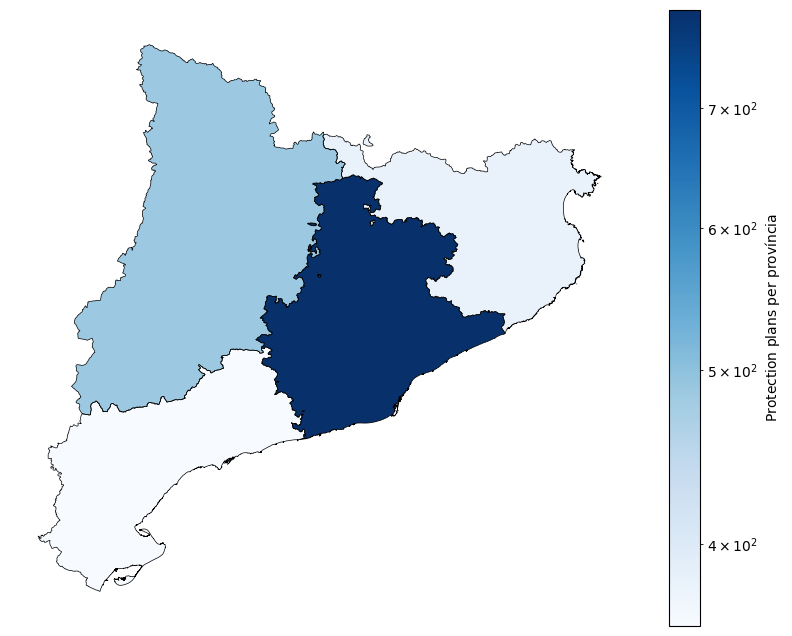

In [19]:
# Merge between shapefile & data
nplans_prov_merge = cat_prov.merge(nplans_prov, how='left', left_on='NOMPROV', right_on='Província')

# Conserve original geometry
nplans_prov_merge_gpd = gpd.GeoDataFrame(nplans_prov_merge, geometry="geometry")

# Plot
fig, ax = plt.subplots(figsize=(10,8))
plot = nplans_prov_merge_gpd.plot(column='# plans',
                                  cmap='Blues',
                                  norm = LogNorm(),
                                  ax=ax,
                                  legend=False)

nplans_prov_merge_gpd.boundary.plot(ax=ax, linewidth=0.5, color='black')

cbar = fig.colorbar(plot.get_children()[0], ax=ax, label=r'Protection plans per $\text{província}$')

ax.set_xticks([])
ax.set_yticks([])
ax.set_xticks([])
ax.set_yticks([])

ax.set_aspect('equal')

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')

ruta = fig_dir+"protection_plans/protection_plans-geo_prov"
plt.savefig(ruta, dpi=500,bbox_inches='tight')

### 3.1.2. Comarques <a class="anchor" id="3.1.2"></a>

In [20]:
protection_plans.replace("Aran","Val d'Aran", inplace=True)

In [21]:
nplans_comar = protection_plans.groupby('Comarca').size().reset_index(name='# plans')

In [22]:
cat_comar = gpd.read_file("cat/comarques/divisions-administratives-v2r1-comarques-100000-20220801.shx")
cat_comar.head()

,CODICOMAR,NOMCOMAR,CAPCOMAR,AREAC5000,geometry
0,01,Alt Camp,Valls,537.6317,"POLYGON ((373635.755 4592021.079, 373669.333 4..."
1,02,Alt Empordà,Figueres,1356.6431,"MULTIPOLYGON (((514495.140 4662167.740, 514492..."
2,03,Alt Penedès,Vilafranca del Penedès,592.5498,"POLYGON ((385914.163 4595999.962, 386085.364 4..."
3,04,Alt Urgell,la Seu d'Urgell,1447.2028,"MULTIPOLYGON (((360736.000 4649167.000, 360624..."
4,05,Alta Ribagorça,el Pont de Suert,427.2234,"POLYGON ((326572.730 4721574.001, 326622.339 4..."


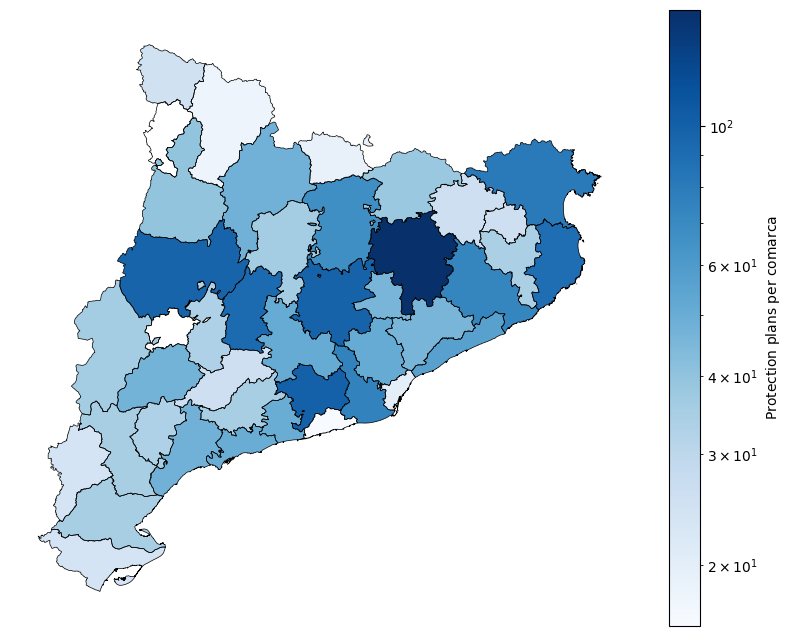

In [23]:
# Merge between shapefile & data
nplans_comar_merge = cat_comar.merge(nplans_comar, how='left', left_on='NOMCOMAR', right_on='Comarca')

# Conserve original geometry
nplans_comar_merge_gpd = gpd.GeoDataFrame(nplans_comar_merge, geometry="geometry")


# Plot
fig, ax = plt.subplots(figsize=(10,8))
plot = nplans_comar_merge_gpd.plot(column='# plans',
                                   cmap='Blues',
                                   norm = LogNorm(),
                                   ax=ax,
                                   legend=False)

nplans_comar_merge_gpd.boundary.plot(ax=ax, linewidth=0.5, color='black')

cbar = fig.colorbar(plot.get_children()[0], ax=ax, label=r'Protection plans per $\text{comarca}$')

ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks([])
ax.set_yticks([])

ax.set_aspect('equal')

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')

ruta = fig_dir+"protection_plans/protection_plans-geo_comar"
plt.savefig(ruta, dpi=500,bbox_inches='tight')

### 3.1.3. Municipis <a class="anchor" id="3.1.3"></a>

In [24]:
nplans_muni = protection_plans.groupby('Municipi').size().reset_index(name='# plans')

In [25]:
cat_muni = gpd.read_file("cat/municipis/divisions-administratives-v2r1-municipis-100000-20230928.shx")
cat_muni.head()

,CODIMUNI,NOMMUNI,CAPMUNI,AREAM5000,CODICOMAR,NOMCOMAR,CAPCOMAR,CODIVEGUE,NOMVEGUE,CAPVEGUE,CODIPROV,NOMPROV,CAPPROV,geometry
0,250019,Abella de la Conca,Abella de la Conca,77.970100,25,Pallars Jussà,Tremp,06,Alt Pirineu,*,25,Lleida,Lleida,"POLYGON ((346678.012 4677003.965, 346688.592 4..."
1,080018,Abrera,Abrera,19.978100,11,Baix Llobregat,Sant Feliu de Llobregat,01,Barcelona,Barcelona,08,Barcelona,Barcelona,"POLYGON ((410315.500 4598888.500, 410888.800 4..."
2,250024,Àger,Àger,160.202600,23,Noguera,Balaguer,03,Lleida,Lleida,25,Lleida,Lleida,"POLYGON ((308157.549 4660767.518, 308220.898 4..."
3,250030,Agramunt,Agramunt,79.359535,38,Urgell,Tàrrega,03,Lleida,Lleida,25,Lleida,Lleida,"MULTIPOLYGON (((342659.900 4635474.900, 342566..."
4,080023,Aguilar de Segarra,Aguilar de Segarra,43.219825,07,Bages,Manresa,07,Catalunya Central,*,08,Barcelona,Barcelona,"POLYGON ((384343.603 4625174.347, 384397.036 4..."


In [ ]:
# Merge between shapefile & data
nplans_muni_merge = cat_muni.merge(nplans_muni, how='left', left_on='NOMMUNI', right_on='Municipi')

# Conserve original geometry
nplans_muni_merge_gpd = gpd.GeoDataFrame(nplans_muni_merge, geometry="geometry")

# Plot
fig, ax = plt.subplots(figsize=(10,8))

plot = nplans_muni_merge_gpd.plot(column='# plans',
                                  cmap='Blues',
                                  norm = LogNorm(),
                                  ax=ax,
                                  legend=False)

nplans_muni_merge_gpd.boundary.plot(ax=ax, linewidth=0.5, color='black')

cbar = fig.colorbar(plot.get_children()[0], ax=ax, label=r'Protection plans per $\text{municipi}$')

ax.set_xticks([])
ax.set_yticks([])

ax.set_aspect('equal')

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')

ruta = fig_dir+"protection_plans/protection_plans-geo_muni"
plt.savefig(ruta, dpi=500,bbox_inches='tight')

## 3.2. Time evolution of protection plans <a class="anchor" id="3.2"></a>

### 3.2.1. Grouped by províncies  <a class="anchor" id="3.2.1"></a>

In [ ]:
protection_plans = protection_plans.sort_values(by="Data de l'últim esdeveniment").reset_index()

In [ ]:
nplans_prov = pd.DataFrame({"Província":[],"# plans":[],"year":[]})

selected_years = np.arange(2018,2023)

for i in range(len(selected_years)):
    protection_plans_year = protection_plans[(protection_plans["Data de l'últim esdeveniment"].dt.year == selected_years[i])]
    nplans_year_prov = protection_plans_year.groupby('Província').size().reset_index(name=f'# plans')
    nplans_year_prov["year"] = int(selected_years[i])
    
    nplans_prov = pd.concat([nplans_prov,nplans_year_prov])

In [ ]:
nplans_prov["year"] = nplans_prov["year"].astype(int)
nplans_prov["# plans"] = nplans_prov["# plans"].astype(int)
nplans_prov.head()

In [ ]:
plt.figure(figsize=(8, 6))

sns.barplot(data=nplans_prov,  x="year",y="# plans", hue="Província", dodge=True)

ruta = fig_dir+"protection_plans/protection_plans-year_prov"
plt.savefig(ruta, dpi=500,bbox_inches='tight')

### 3.2.2. Grouped by typology  <a class="anchor" id="3.2.2"></a>

In [ ]:
nplans_type = pd.DataFrame({"Nom del pla":[],"# plans":[],"year":[]})

selected_years = np.arange(2018,2023)

for i in range(len(selected_years)):
    protection_plans_year = protection_plans[(protection_plans["Data de l'últim esdeveniment"].dt.year == selected_years[i])]
    nplans_year_type = protection_plans_year.groupby('Nom del pla').size().reset_index(name=f'# plans')
    nplans_year_type["year"] = int(selected_years[i])
    
    nplans_type = pd.concat([nplans_type,nplans_year_type])

nplans_type["year"] = nplans_type["year"].astype(int)

In [ ]:
plt.figure(figsize=(9, 6))

sns.barplot(data=nplans_type,  x="year",y="# plans", hue="Nom del pla", dodge=True)

plt.legend(bbox_to_anchor=(1.25,1), loc="upper right")
ruta = fig_dir+"protection_plans/protection_plans-year_type"
plt.savefig(ruta, dpi=500,bbox_inches='tight')

In [ ]:
for year in selected_years:
    

plt.pie(nplans_type["# plans"], labels=nplans_type["Nom del pla"], autopct='%1.1f%%', startangle=140)
plt.show()
nplans_type["year"] = nplans_type["year"].astype(int)

## 3.3. Protection plans divided  <a class="anchor" id="3.3"></a>

### 3.3.1. Grouped by typology  <a class="anchor" id="3.3.2"></a>

### 3.3.2. Grouped by typology and província  <a class="anchor" id="3.3.2"></a>

In [ ]:
nplans_type_prov = protection_plans.groupby(['Nom del pla',"Província"]).size().reset_index(name='# plans')
nplans_type_prov.head()

In [ ]:
plt.figure(figsize=(10, 5))

sns.barplot(data=nplans_type_prov,  x="Nom del pla",y="# plans", hue="Província", dodge=True)

plt.xticks(rotation = 90)

ruta = fig_dir+"protection_plans/protection_plans-type_prov"
plt.savefig(ruta, dpi=500,bbox_inches='tight')